**There are two ways to obtain word embeddings:**

Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called pre-trained word embeddings.

In [1]:
from tensorflow.keras import layers

# The Embedding layer takes at least two arguments:
# 1) the number of possible tokens, here 1000 (1 + maximum word index),
# 2) the dimensionality of the embeddings, here 64.
embedding_layer = layers.Embedding(1000, 64)

**The Embedding layer takes as input a 2D tensor of integers,**
of shape (samples, sequence_length), where each entry is a sequence of integers.
It returns a 3D floating-point tensor of shape(samples, sequence_length, embedding_dimensionality).
The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors.
It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Turn our lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
from tensorflow.keras.models import Sequential

model = Sequential()
# We specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs
model.add(layers.Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, our activations have shape `(samples, maxlen, dimensionality(8))`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(layers.Flatten())

# We add the classifier on top
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6671 - accuracy: 0.6301 - val_loss: 0.6159 - val_accuracy: 0.6968
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5376 - accuracy: 0.7538 - val_loss: 0.5231 - val_accuracy: 0.7312
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4592 - accuracy: 0.787

In [4]:
# From raw text to word embeddings
import os

imdb_dir = '../input/embedding2/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
# Tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # Cut reviews after 100 words
training_samples = 200  # Train on 200 samples
validation_samples = 10000  # Validate on 10000 samples
max_words = 10000  # Consider only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print(f"Shape of data tensor: {data.shape}")
print(f"Shape of label tensor: {labels.shape}")

# Split the data into a training set and a validation set.
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
# Pre-process the embeddings
# parsing the GloVe word-embedding file

glove_dir = '../input/glove-word'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [7]:
# Now let's build an embedding matrix that we will be able to load into an Embedding layer.
# It must be a matrix of shape (max_words, embedding_dim),
# where each entry i contains the embedding_dim-dimensional
# vector for the word of index i in our reference word index (built during tokenization).

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [8]:
# Define a model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


**Load the GloVe embeddings in the model**
The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Let's just load the GloVe matrix we prepared into our Embedding layer, the first layer in our model:

In [9]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #freeze the embedding layer

In [10]:
# Train and evaluate
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 101ms/step - loss: 1.6593 - acc: 0.5500 - val_loss: 0.6916 - val_acc: 0.5382
Epoch 2/10
7/7 [==============================] - 0s 72ms/step - loss: 0.5944 - acc: 0.6950 - val_loss: 1.4616 - val_acc: 0.4967
Epoch 3/10
7/7 [==============================] - 0s 73ms/step - loss: 0.6178 - acc: 0.6400 - val_loss: 0.8023 - val_acc: 0.5176
Epoch 4/10
7/7 [==============================] - 0s 77ms/step - loss: 0.3265 - acc: 0.8600 - val_loss: 1.1511 - val_acc: 0.5026
Epoch 5/10
7/7 [==============================] - 0s 71ms/step - loss: 0.2420 - acc: 0.9200 - val_loss: 1.3176 - val_acc: 0.5040
Epoch 6/10
7/7 [==============================] - 0s 76ms/step - loss: 0.1775 - acc: 0.9350 - val_loss: 0.7358 - val_acc: 0.5637
Epoch 7/10
7/7 [==============================] - 0s 75ms/step - loss: 0.0762 - acc: 1.0000 - val_loss: 0.7421 - val_acc: 0.5712
Epoch 8/10
7/7 [==============================] - 0s 75ms/step - loss: 0.0607 - acc: 0.9950 - va

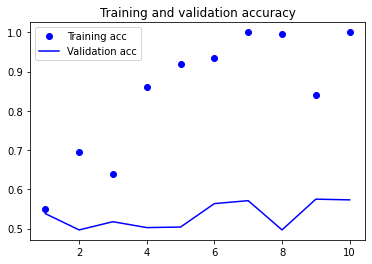

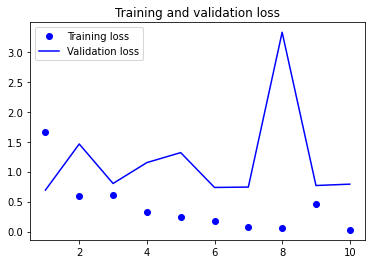

In [11]:
# Plot performance over time

import matplotlib.pyplot as plt

def plot_performance_over_time(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
plot_performance_over_time(history)

In [12]:
# training the same model without pretained word embedding

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 137ms/step - loss: 0.6921 - acc: 0.4600 - val_loss: 0.6919 - val_acc: 0.5225
Epoch 2/10
7/7 [==============================] - 0s 73ms/step - loss: 0.5092 - acc: 0.9900 - val_loss: 0.6965 -

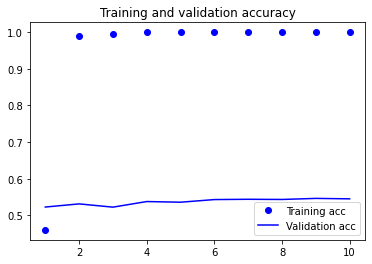

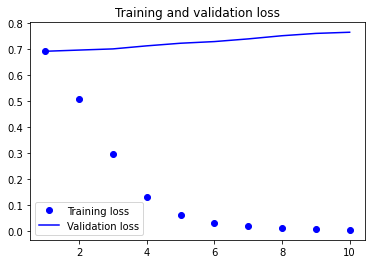

In [13]:
plot_performance_over_time(history)

Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If we increase the number of training samples, this will quickly stop being the case. Let's try it with an alternative model:

In [14]:
training_samples = 800 # Increase training set to 1000
validation_samples = 1000

alt_x_train = data[:training_samples]
alt_y_train = labels[:training_samples]
alt_x_val = data[training_samples: training_samples + validation_samples]
alt_y_val = labels[training_samples: training_samples + validation_samples]


alt_model = Sequential()
alt_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
alt_model.add(Flatten())
alt_model.add(Dense(32, activation='relu'))
alt_model.add(Dense(1, activation='sigmoid'))

alt_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = alt_model.fit(alt_x_train, alt_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(alt_x_val, alt_y_val))

Epoch 1/10
25/25 [==============================] - 1s 15ms/step - loss: 0.6918 - acc: 0.5138 - val_loss: 0.6889 - val_acc: 0.5340
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.4249 - acc: 0.9663 - val_loss: 0.6896 - val_acc: 0.5430
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 0.1267 - acc: 0.9962 - val_loss: 0.6711 - val_acc: 0.5970
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0268 - acc: 1.0000 - val_loss: 0.7093 - val_acc: 0.5850
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.7282 - val_acc: 0.6040
Epoch 6/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.7428 - val_acc: 0.6160
Epoch 7/10
25/25 [==============================] - 0s 8ms/step - loss: 3.3114e-04 - acc: 1.0000 - val_loss: 0.7730 - val_acc: 0.6230
Epoch 8/10
25/25 [==============================] - 0s 8ms/step - loss: 7.9972e-05 - 

**Evaluation**
Finally, let's evaluate the model with pre-trained embeddings on the test data. First, we will need to tokenize the test data:

In [15]:
# tokenize the data of the test set
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [16]:
# Load and evaluate the model on test set
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.7972 - acc: 0.5698


[0.797152042388916, 0.5698400139808655]